# Initialization

In [1]:
# Simple fork of the original git to fix tqdm progress bar in google collab
!pip install --no-cache-dir git+https://github.com/lowener/sentence-transformers
!pip install ngt

  Cloning https://github.com/lowener/sentence-transformers to /tmp/pip-req-build-3jkoa33z
  Running command git clone -q https://github.com/lowener/sentence-transformers /tmp/pip-req-build-3jkoa33z
     |████████████████████████████████| 675kB 8.7MB/s 
     |████████████████████████████████| 3.8MB 23.3MB/s 
     |████████████████████████████████| 890kB 49.7MB/s 
     |████████████████████████████████| 1.1MB 49.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.2-cp36-none-any.whl size=81305 sha256=be125489f660405a1969e5d75793dad867593cac5b9fc51bea9a43fab2c003b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-lvcsvcsr/wheels/81/95/80/09d916b36bc33d2fae316beed24428cb64c451c23e23a896d1
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e8379f87e8226ee177f2562866af8f707e0ad4a4d0f63fa7778caaad84947b41
  Stored in directory: /tmp/pip-ephem-wheel-cache-lvcsvcsr/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19c

In [2]:
import numpy as np
import torch
import math
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets, model_selection
from matplotlib import pyplot as plt
import itertools
from sentence_transformers import SentenceTransformer, losses, evaluation
import ngt
from sklearn import metrics
import seaborn as sn
import ngtpy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
SEED = 2020
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

# Data Loader for Triplet Learning on 20 Newsgroup dataset

In [5]:
def build_triplets(classid: int, X: np.array, Y: np.array):
  # TODO: Select more often negative from the same 'group' (ex: 'comp' for 'comp.sys.ibm.pc.hardware')
  # OR use negative anchor on two groups that fine-tuning can't separate very well
  positive_idx = np.where(Y == classid)[0]
  negative_idx = np.where(Y != classid)[0]
  # Those groups have common features. Make sure that they are well fine-tuned
  focus_negative = {
      0: [15, 19],
      1: [2,3,4,5, 12],
      2: [1,3,4,5, 12],
      3: [1,2,4,5, 12],
      4: [1,2,3,5, 12],
      5: [1,2,3,4, 12],
      7: [8,9,10],
      8: [7,9,10],
      9: [7,8,10],
      10: [7,8,9],
      11: [12,13,14],
      12: [1, 2, 3, 4, 5,11,13,14],
      13: [11,12,14],
      14: [11,12,13],
      15: [0, 19],
      16: [17,18,19],
      17: [16,18,19],
      18: [16,17,19],
      19: [0, 15, 16,17,18],
  }
  combinations = itertools.combinations(positive_idx, 2)
  combinations = list(combinations)
  triplets = []
  np.random.shuffle(negative_idx)
  choose_focus = np.random.random((len(combinations)))
  neg = negative_idx[:len(combinations)]
  for c, n, cf in zip(combinations, neg, choose_focus):
    # Choose random example 60% of the time
    # Choose a focus example 40% of the time
    if classid in focus_negative and cf < 0.4: 
      neg_array = focus_negative[classid]
      neg_category = np.random.choice(neg_array)
      n = np.random.choice(np.where(Y == neg_category)[0])
      triplets.append(list(c) + [n])
    else:
      triplets.append(list(c) + [n])
  return triplets
  

In [6]:
class NewsDataset(Dataset):
  def __init__(self, model, subset='train'):
    if model is None or (subset != 'train' and subset != 'test'):
      raise AttributeError("Model is None or subset is not train/test")
    self.model = model
    self.X, self.y = datasets.fetch_20newsgroups(subset=subset, remove=('headers', 'footers', 'quotes'), return_X_y=True)
    if subset == 'test': # Reduce the validation data by 2/3 
      self.X = self.X[:len(self.X)//3]
      self.y = self.y[:len(self.y)//3]
    for i in range(len(self.X)):
      self.X[i] = model.tokenize(self.X[i])
    self.triplets = []
    for classid in np.unique(self.y):
      self.triplets += build_triplets(classid, self.X, self.y)
    self.y = torch.tensor(self.y, dtype=torch.long)

  def __len__(self,):
    return len(self.triplets)

  def __getitem__(self, index):
    triplet_idx = self.triplets[index]
    anchor = self.X[triplet_idx[0]]
    pos = self.X[triplet_idx[1]]
    neg = self.X[triplet_idx[2]]
    label = self.y[triplet_idx[0]]
    return [anchor, pos, neg], label
    
  

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Training

In [ ]:
batch_size = 32
num_epochs = 4
model_save_path = '/content/gdrive/My Drive/Ubisoft/save_model_opti_triplets2'

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
train_data = NewsDataset(model)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=6)
train_loss = losses.TripletLoss(model=model)


test_data = NewsDataset(model, subset='test')
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=batch_size,num_workers=4)
evaluator = evaluation.TripletEvaluator(test_dataloader)

warmup_steps = math.ceil(len(train_data) * num_epochs / batch_size * 0.1)
evaluation_steps = math.ceil(len(train_data) * 0.34 / batch_size)
print(len(train_data) // batch_size)
print(evaluation_steps)
print(len(test_data) // batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils.py:831: FutureWarning: Parameter max_len is deprecated and will be removed in a future release. Use model_max_length instead.
  category=FutureWarning,


6717
2285
1490


In [ ]:
torch.cuda.is_available()

True

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=evaluation_steps,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

# Approximate Nearest Neighbor Classification

## Encode the sentences

In [9]:
model_save_path = '/content/gdrive/My Drive/Ubisoft/save_model_opti_triplets2'
model = SentenceTransformer(model_save_path)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils.py:831: FutureWarning: Parameter max_len is deprecated and will be removed in a future release. Use model_max_length instead.
  category=FutureWarning,


In [ ]:
X_train, y_train = datasets.fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_train_encoded = model.encode(X_train, batch_size=32, show_progress_bar=True)
X_test, y_test = datasets.fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_test_encoded = model.encode(X_test, batch_size=32, show_progress_bar=True)

In [13]:
np.save('/content/gdrive/My Drive/Ubisoft/X_train_encoded', X_train_encoded)
np.save('/content/gdrive/My Drive/Ubisoft/X_test_encoded', X_test_encoded)
np.save('/content/gdrive/My Drive/Ubisoft/y_train', y_train)

## Build kNN index

In [14]:
dim = len(X_train_encoded[0])
ngtpy.create(b"IndexEncoded", dim, distance_type='L1')
index = ngtpy.Index(b"IndexEncoded")
index.batch_insert(X_train_encoded)
index.save()

## Query Index

In [15]:
def classify(query: np.array, index: ngtpy.Index, y_index: np.array, size_k: int = 3, weight: bool = True) -> np.array:
  result = np.zeros((len(query)))
  for i in range(len(query)):
    vote_array = np.zeros(20)
    query_res = index.search(query[i], size=size_k)
    for neighbor in query_res:
      if neighbor[1] == 0:
        vote_array[y_index[int(neighbor[0])]] = 1
        break
      if weight:
        vote_array[y_index[int(neighbor[0])]] += 1 / neighbor[1]
      else:
        vote_array[y_index[int(neighbor[0])]] += 1
      #print('Neighbor: ' + str(i) + ', Index: ' + str(o[0]) + ', Class: ' + str(y_index[o[0]]) + ', Distance: ' + str(o[1]))
    result[i] = np.argmax(vote_array)
  return result

In [16]:
res = classify(X_test_encoded, index, y_train, size_k=9, weight=True)

## Classification report

In [17]:
print(metrics.classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.37      0.41      0.39       319
           1       0.63      0.70      0.66       389
           2       0.63      0.62      0.63       394
           3       0.64      0.63      0.64       392
           4       0.50      0.72      0.59       385
           5       0.85      0.73      0.79       395
           6       0.78      0.77      0.77       390
           7       0.83      0.66      0.73       396
           8       0.76      0.68      0.71       398
           9       0.81      0.83      0.82       397
          10       0.89      0.88      0.88       399
          11       0.60      0.73      0.66       396
          12       0.63      0.54      0.58       393
          13       0.85      0.80      0.82       396
          14       0.74      0.76      0.75       394
          15       0.73      0.69      0.71       398
          16       0.52      0.60      0.56       364
          17       0.90    

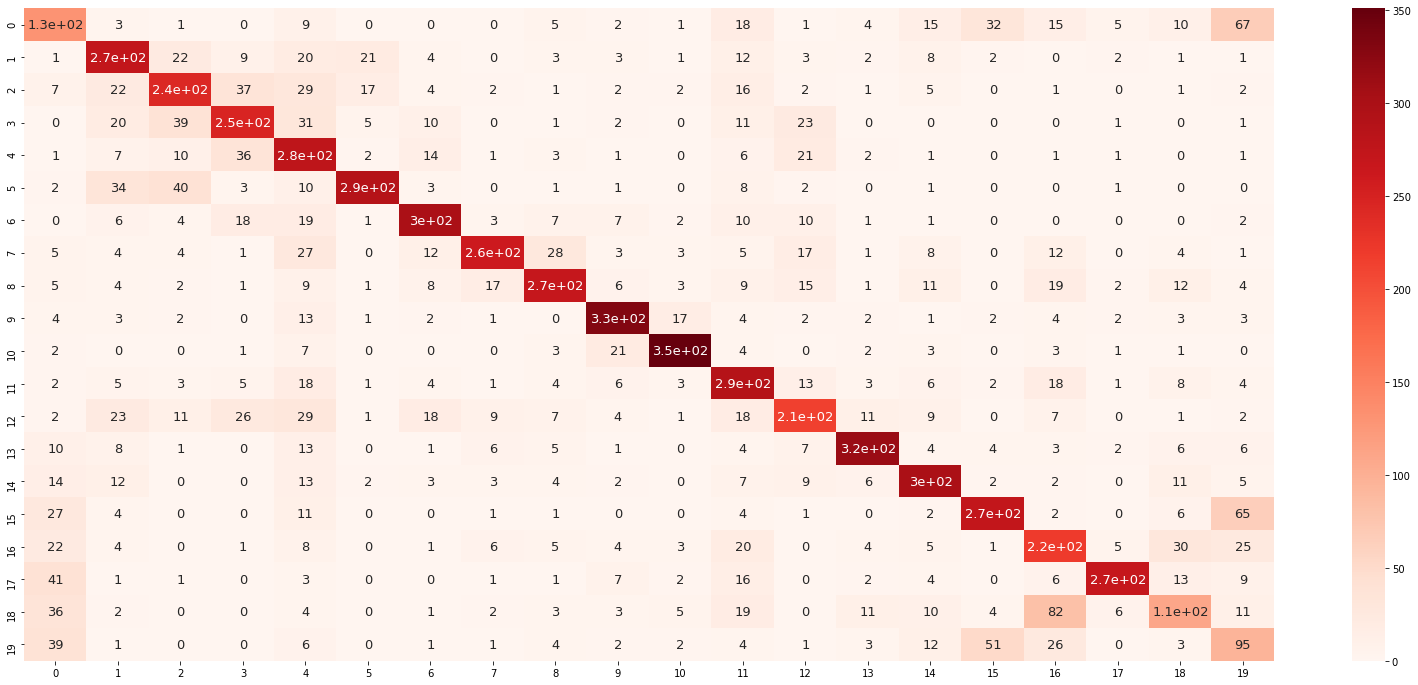

In [18]:
cfm = metrics.confusion_matrix(y_test, res)
plt.figure(None,(28,12))
sn.heatmap(cfm,annot=True, annot_kws={"size": 13}, cmap=plt.cm.Reds)

## Compare with base model

In [ ]:
model_base = SentenceTransformer('distilbert-base-nli-mean-tokens')
#res=model.evaluate(evaluator)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils.py:831: FutureWarning: Parameter max_len is deprecated and will be removed in a future release. Use model_max_length instead.
  category=FutureWarning,


In [ ]:
X_train_encoded_base = model_base.encode(X_train, batch_size=64, show_progress_bar=True)
X_test_encoded_base = model_base.encode(X_test, batch_size=64, show_progress_bar=True)

In [ ]:
ngtpy.create(b"IndexEncoded_base", dim, distance_type='L1')
index_base = ngtpy.Index(b"IndexEncoded_base")
index_base.batch_insert(X_train_encoded_base)
index_base.save()

In [ ]:
res_base = classify(X_test_encoded_base, index_base, y_train, size_k=9, weight=True)

In [ ]:
print(metrics.classification_report(y_test, res_base))

              precision    recall  f1-score   support

           0       0.33      0.28      0.30       319
           1       0.42      0.41      0.42       389
           2       0.42      0.47      0.44       394
           3       0.37      0.39      0.38       392
           4       0.34      0.49      0.40       385
           5       0.42      0.49      0.45       395
           6       0.63      0.70      0.66       390
           7       0.68      0.56      0.61       396
           8       0.67      0.50      0.57       398
           9       0.82      0.70      0.75       397
          10       0.82      0.76      0.79       399
          11       0.41      0.52      0.46       396
          12       0.45      0.27      0.34       393
          13       0.70      0.66      0.68       396
          14       0.71      0.66      0.68       394
          15       0.52      0.71      0.60       398
          16       0.40      0.54      0.46       364
          17       0.67    

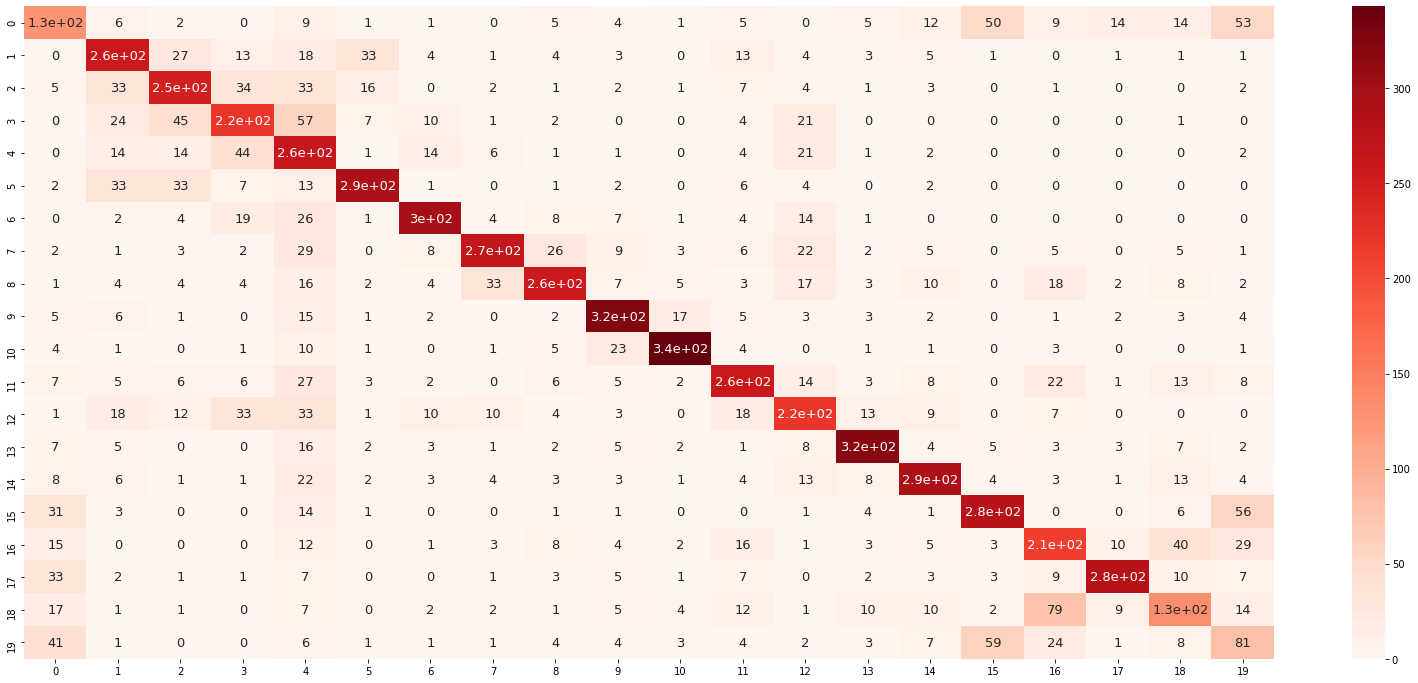

In [ ]:
cfm_base = metrics.confusion_matrix(y_test, res_base)
plt.figure(None,(28,12))
sn.heatmap(cfm_base,annot=True, annot_kws={"size": 13}, cmap=plt.cm.Reds)

In [ ]:
labels

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [20]:
X_test[29]

"\n\nI don't know about Canada, but I have heard from people\ndoing translation work in Papua New Quinea, that they\nlike them and have had good response on service.\n\nAnother is seriously considering buying one.\n"